In [2]:
import pandas as pd

file_path = "../raw_data/news_all.csv"
data = pd.read_csv(file_path)

print(data.head())
print("数据加载完成！")

                                                Text  Label
0  Amazon to create 500 new jobs in Mississippi a...      2
1  GE's stock rises 1% premarket, set to trade ab...      2
2  CN Rail Strike Begins, Threatening Canada Oil,...      0
3  Hong Kong Airlines to cut 400 jobs, ask employ...      0
4  3 Top-Performing Mutual Funds to Consider for ...      1
数据加载完成！


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['Label'])
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'], data['Label_encoded'], test_size=0.4, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("数据划分完成！")

数据划分完成！


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

train_bert_inputs = tokenize_texts(X_train)
val_bert_inputs = tokenize_texts(X_val)
test_bert_inputs = tokenize_texts(X_test)

print("FinBERT 输入特征生成完成！")

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FinBERT 输入特征生成完成！


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
lstm_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(X_train)
def prepare_lstm_inputs(texts):
    sequences = lstm_tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=128, padding="post", truncating="post")

X_train_lstm = prepare_lstm_inputs(X_train)
X_val_lstm = prepare_lstm_inputs(X_val)
X_test_lstm = prepare_lstm_inputs(X_test)

print("LSTM 输入特征生成完成！")

LSTM 输入特征生成完成！


In [10]:
# LSTM输入数据结构修改
train_inputs = {'lstm_input': X_train_lstm}
val_inputs = {'lstm_input': X_val_lstm}
test_inputs = {'lstm_input': X_test_lstm}

# BERT输入数据结构修改
train_inputs['bert_input_ids'] = train_bert_inputs['input_ids']
train_inputs['bert_attention_mask'] = train_bert_inputs['attention_mask']

val_inputs['bert_input_ids'] = val_bert_inputs['input_ids']
val_inputs['bert_attention_mask'] = val_bert_inputs['attention_mask']

test_inputs['bert_input_ids'] = test_bert_inputs['input_ids']
test_inputs['bert_attention_mask'] = test_bert_inputs['attention_mask']

print("FinBERT 输入特征和LSTM输入特征结构修改完成！")

FinBERT 输入特征和LSTM输入特征结构修改完成！


In [33]:
import json
tokenizer_path = "lstm_tokenizer.json"
with open(tokenizer_path, "w", encoding="utf-8") as f:
    f.write(lstm_tokenizer.to_json())

print(f"LSTM Tokenizer 已保存到 {tokenizer_path}")

LSTM Tokenizer 已保存到 lstm_tokenizer.json


In [35]:
import joblib
encoder_path = "label_encoder.joblib"
joblib.dump(label_encoder, encoder_path)

print(f"LabelEncoder 已保存到 {encoder_path}")

LabelEncoder 已保存到 label_encoder.joblib


In [12]:
from tensorflow.keras.layers import Layer

class FinBERTLayer(Layer):
    def __init__(self, pretrained_model_name="ProsusAI/finbert", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(pretrained_model_name)

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        return bert_outputs.last_hidden_state[:, 0, :]  # CLS token 输出

In [14]:
import tensorflow as tf 
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from transformers import TFBertModel

finbert_model = TFBertModel.from_pretrained("ProsusAI/finbert")

def build_fusion_model():
    lstm_input = Input(shape=(128,), name="lstm_input")
    embedding = Embedding(input_dim=10000, output_dim=128)(lstm_input)
    lstm_output = LSTM(128, return_sequences=False)(embedding)
    lstm_dense = Dense(64, activation="relu")(lstm_output)
    lstm_dropout = Dropout(0.3)(lstm_dense)
    bert_input_ids = Input(shape=(128,), dtype=tf.int32, name="bert_input_ids")
    bert_attention_mask = Input(shape=(128,), dtype=tf.int32, name="bert_attention_mask")
    bert_output = FinBERTLayer()([bert_input_ids, bert_attention_mask])
    bert_dense = Dense(64, activation="relu")(bert_output)
    bert_dropout = Dropout(0.3)(bert_dense)

    merged = Concatenate()([lstm_dropout, bert_dropout])
    fusion_dense = Dense(64, activation="relu")(merged)
    fusion_dropout = Dropout(0.3)(fusion_dense)
    output = Dense(3, activation="softmax")(fusion_dropout)

    model = Model(
        inputs=[lstm_input, bert_input_ids, bert_attention_mask],
        outputs=output
    )
    return model

fusion_model = build_fusion_model()
fusion_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
fusion_model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ lstm_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_attention_mask │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fin_bert_layer      │ (None, 768)       │          0 │ bert_input_ids[0… │
│ (FinBERTLayer)      │                   │            │ bert_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ fin_bert_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,507 (5.64 MB)

 Trainable params: 1,477,507 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = fusion_model.fit(
    [X_train_lstm, train_bert_inputs['input_ids'], train_bert_inputs['attention_mask']],
    y_train,
    validation_data=(
        [X_val_lstm, val_bert_inputs['input_ids'], val_bert_inputs['attention_mask']],
        y_val
    ),
    epochs=3,   
    batch_size=32,  
    verbose=1 
)


Epoch 1/3


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'bert_input_ids', 'bert_attention_mask']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 695s 3s/step - accuracy: 0.7680 - loss: 0.6012 - val_accuracy: 0.8298 - val_loss: 0.4501
Epoch 2/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 1620s 7s/step - accuracy: 0.8303 - loss: 0.4649 - val_accuracy: 0.8439 - val_loss: 0.4146
Epoch 3/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 701s 3s/step - accuracy: 0.8433 - loss: 0.4213 - val_accuracy: 0.8383 - val_loss: 0.4106


In [91]:
fusion_model.save('fusion_model.h5')

In [18]:
test_loss, test_accuracy = fusion_model.evaluate(
    [X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']],
    y_test
)

print(f"测试集上的准确率: {test_accuracy:.4f}")
print(f"测试集上的损失: {test_loss:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8421 - loss: 0.4110
测试集上的准确率: 0.8447
测试集上的损失: 0.3928


In [35]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel

# 加载ProsusAI的FinBERT（PyTorch版本）
model_name = 'ProsusAI/finbert'  # 使用ProsusAI FinBERT模型（PyTorch版本）
finbert_model = BertModel.from_pretrained(model_name, output_attentions=True)  # 加载BERT模型，包含attention
tokenizer = BertTokenizer.from_pretrained(model_name)


In [37]:


# 1. 获取FinBERT的注意力权重
def get_attention_map(text):
    # 确保输入是字符串类型
    if isinstance(text, np.ndarray):  # 如果是numpy.ndarray类型
        text = text.tolist()  # 将它转换为列表
    
    if isinstance(text, list):  # 如果是列表，则检查每个元素
        text = ' '.join([str(t) for t in text])  # 将文本列表转换为一个单一字符串
    
    if not isinstance(text, str):  # 如果不是字符串
        raise ValueError(f"Expected text input to be of type 'str', but got {type(text)}.")
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # 获取模型的输出，包括注意力权重
    outputs = finbert_model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # 获取所有层的注意力
    last_layer_attention = attentions[-1]  # 选择最后一层的注意力
    attention_weights = last_layer_attention.squeeze(0)  # 删除batch维度
    return attention_weights

# 2. 获取所有训练数据的注意力权重
attention_maps = []
for text in X_train_lstm:  # 假设X_train_lstm中包含所有文本
    attention_map = get_attention_map(text)  # 获取每条文本的注意力权重
    attention_maps.append(attention_map[0].detach().numpy().flatten())  # 扁平化每个文本的注意力权重

# 3. 使用PCA降维
attention_matrix = np.array(attention_maps)  # 将所有文本的注意力权重合并成一个矩阵

# 使用PCA将高维数据降到3D空间
pca = PCA(n_components=3)
reduced_attention = pca.fit_transform(attention_matrix)

# 4. 获取标签数据（y_train）并绘制PCA结果
y_train = np.array(y_train)  # 你的情感标签数据

# 5. 绘制3D PCA可视化结果，区分情感标签
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 使用不同的颜色区分三类情感（消极、中性、积极）
scatter = ax.scatter(reduced_attention[:, 0], reduced_attention[:, 1], reduced_attention[:, 2], c=y_train, cmap='viridis', s=50)

# 添加标题和标签
ax.set_title("3D PCA of Attention Weights Across All Texts (Colored by Sentiment)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Sentiment Labels')

plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6993,) + inhomogeneous part.

In [52]:
from sklearn.metrics import f1_score, classification_report

y_pred_prob = fusion_model.predict([X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']])
y_pred = y_pred_prob.argmax(axis=1) 

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"融合模型的 F1-Score: {f1:.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names=["Positive", "Neutral", "Negative"]))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'bert_input_ids', 'bert_attention_mask']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step
融合模型的 F1-Score: 0.8307

分类报告：
              precision    recall  f1-score   support

    Positive       0.79      0.55      0.65       293
     Neutral       0.86      0.95      0.90      1642
    Negative       0.77      0.60      0.67       396

    accuracy                           0.84      2331
   macro avg       0.81      0.70      0.74      2331
weighted avg       0.83      0.84      0.83      2331



In [125]:
from sklearn.preprocessing import label_binarize

# 将真实标签二值化
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2]) 
n_classes = y_test_binarized.shape[1]  

In [129]:
from sklearn.metrics import roc_curve, auc

# 初始化变量
fpr = dict()  
tpr = dict()  
roc_auc = dict()  

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

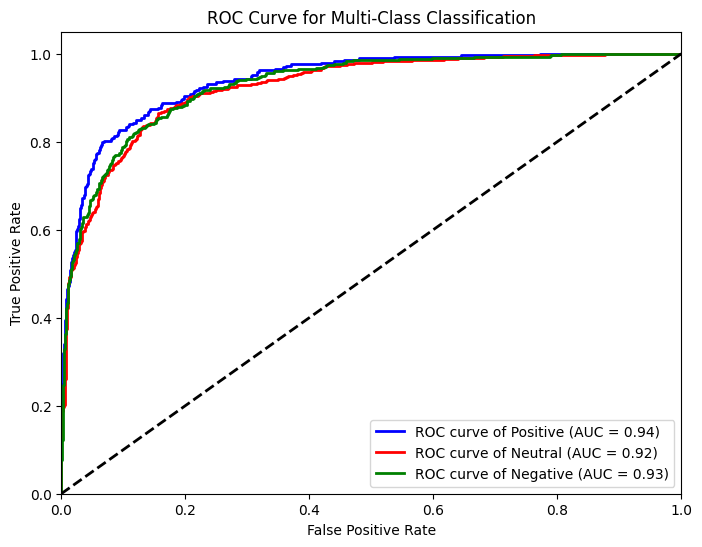

In [131]:
import matplotlib.pyplot as plt

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green'] 
class_names = ['Positive', 'Neutral', 'Negative']  

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

In [147]:
import numpy as np

np.savez('fusion_roc_data.npz', fpr=fpr, tpr=tpr, roc_auc=roc_auc)

print("ROC data has been saved to 'roc_data.npz'")

ROC data has been saved to 'roc_data.npz'


In [55]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)  
y_test_encoded = label_encoder.transform(y_test)     

复用缓存的预测结果...


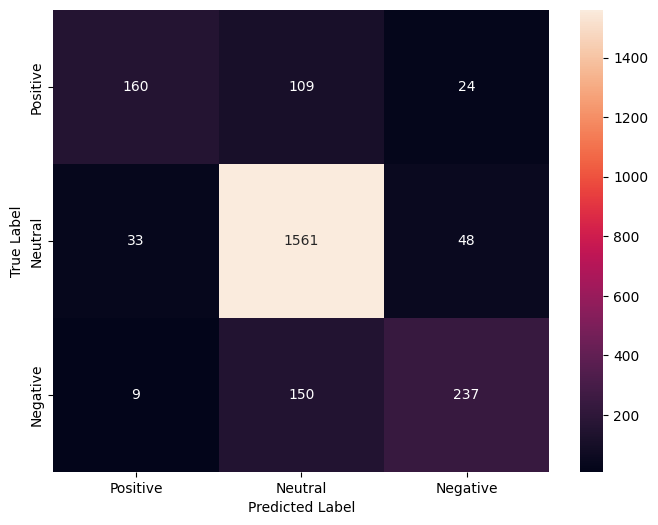

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

if 'y_pred' not in globals():
    print("正在生成预测结果...")
    y_pred_prob = fusion_model.predict([X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']])
    y_pred = y_pred_prob.argmax(axis=1)  
else:
    print("复用缓存的预测结果...")

cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Positive", "Neutral", "Negative"],
            yticklabels=["Positive", "Neutral", "Negative"])

plt.title("")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [79]:
fusion_model.save("fusion_model.keras")

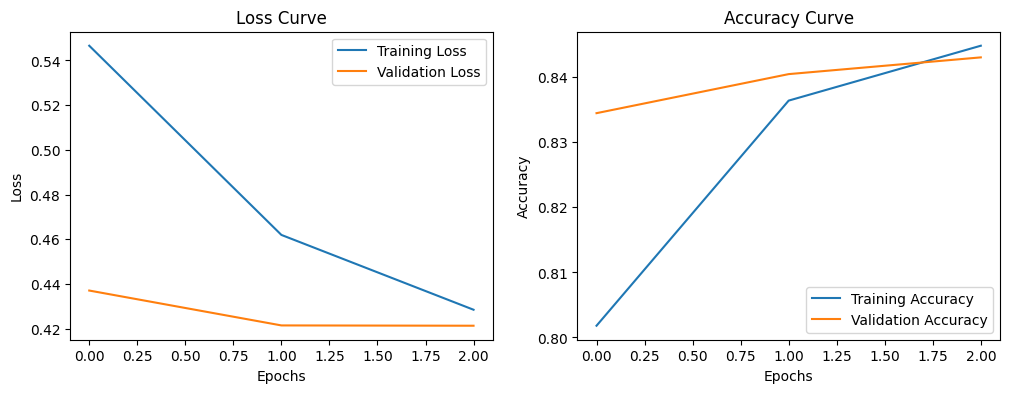

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()